In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from skimage.feature import graycomatrix, graycoprops
from skimage import io, color, filters
from tqdm import tqdm

In [2]:
model_path = "../models/Random_Forest_best.pkl"
dataset_path = "../data/raw/TFD Textile Dataset"   # adjust if different
report_path = "../reports/inference_results.csv"

print("📂 Loading trained model...")
model = joblib.load(model_path)
print("✅ Model loaded successfully!")

📂 Loading trained model...
✅ Model loaded successfully!


In [3]:
def extract_features(img_path):
    img = io.imread(img_path)
    img = cv2.resize(img, (256, 256))

    # Convert to RGB if grayscale
    if len(img.shape) == 2:
        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    R, G, B = img[:,:,0], img[:,:,1], img[:,:,2]

    mean_R, mean_G, mean_B = np.mean(R), np.mean(G), np.mean(B)
    std_R, std_G, std_B = np.std(R), np.std(G), np.std(B)

    gray = color.rgb2gray(img)
    contrast = graycoprops(graycomatrix((gray*255).astype('uint8'), [1], [0]), 'contrast')[0, 0]
    smoothness = 1 - 1 / (1 + std_R + std_G + std_B)
    entropy = -np.sum(gray * np.log2(gray + 1e-9))
    edge_density = np.mean(filters.sobel(gray))

    return [mean_R, mean_G, mean_B, std_R, std_G, std_B, contrast, smoothness, entropy, edge_density]


In [4]:
image_paths = []
for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith((".jpg", ".png", ".jpeg")):
            image_paths.append(os.path.join(root, file))
            
image_paths = image_paths[:12]  # limit for display
print(f"🧵 Found {len(image_paths)} sample images for prediction.")

results = []
for img_path in tqdm(image_paths):
    feats = extract_features(img_path)
    pred = model.predict([feats])[0]
    prob = model.predict_proba([feats]).max()
    results.append({"file": os.path.basename(img_path), "predicted_defect": pred, "confidence": prob})

df_preds = pd.DataFrame(results)
df_preds.to_csv(report_path, index=False)
print(f"\n✅ Predictions saved to: {report_path}")


🧵 Found 12 sample images for prediction.


100%|██████████| 12/12 [00:01<00:00,  7.20it/s]



✅ Predictions saved to: ../reports/inference_results.csv


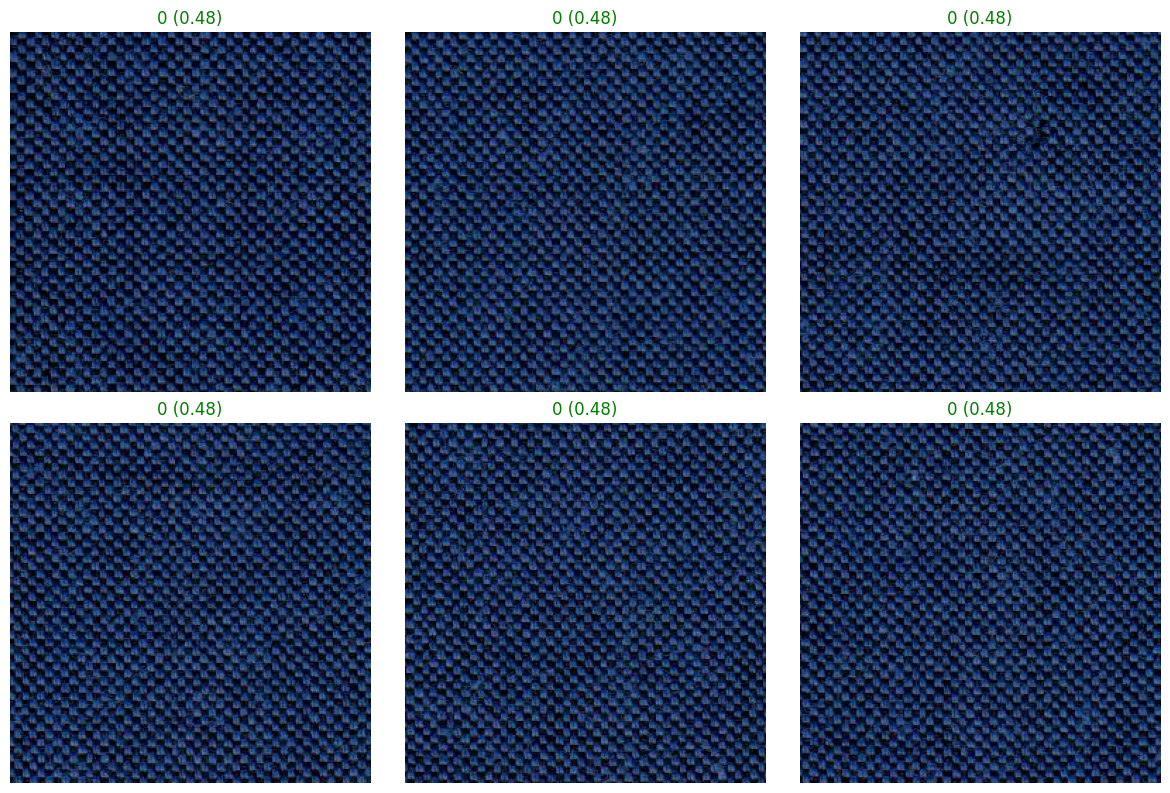


🚀 Deployment simulation completed successfully!


In [6]:
# -----------------------------------------------
# 4️⃣ Visualize Results (Fixed for Subfolders)
# -----------------------------------------------
fig, axes = plt.subplots(2, 3, figsize=(12, 8))

for ax, (i, row) in zip(axes.flatten(), df_preds.iterrows()):
    # find image path (search recursively)
    found_path = None
    for root, dirs, files in os.walk(dataset_path):
        if row["file"] in files:
            found_path = os.path.join(root, row["file"])
            break

    if found_path:
        img = io.imread(found_path)
        ax.imshow(img)
        ax.set_title(f"{row['predicted_defect']} ({row['confidence']:.2f})", color='green')
    else:
        ax.text(0.5, 0.5, "Image not found", ha='center', va='center', fontsize=12, color='red')

    ax.axis('off')

plt.tight_layout()
plt.show()

print("\n🚀 Deployment simulation completed successfully!")
